In [1]:
# !pip3 install shap

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import iplot 
import plotly.io as pio
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import lightgbm as lgb
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
# pd.set_option('future.no_silent_downcasting', True)

- 'Casual belt'
- 'Shoe care'
- 'Mix & match jacket'
- 'Crew-neck sweater'
- 'T-shirt SS'
- 'Dress belt'
- 'Jeans'
- 'Polo SS'
- 'Boxershort'
- 'Chino'
- 'Dress Shirt LS'
- 'Socks'
- 'Short'
- '5-pocket'
- 'Mix & match trousers'
- 'Suit'
- 'V-neck sweater'
- 'Casual shirt LS'

# Functions

In [3]:
dutch_holidays = [
    # -----------------
    # FIXED HOLIDAYS
    # -----------------

    # New Year's Day
    "2017-01-01","2018-01-01","2019-01-01","2020-01-01","2021-01-01","2022-01-01",
    "2023-01-01","2024-01-01","2025-01-01","2026-01-01","2027-01-01",

    # King’s Day
    "2017-04-27","2018-04-27","2019-04-27","2020-04-27","2021-04-27","2022-04-27",
    "2023-04-27","2024-04-27","2025-04-27","2026-04-27","2027-04-27",

    # Christmas
    "2017-12-25","2018-12-25","2019-12-25","2020-12-25","2021-12-25","2022-12-25",
    "2023-12-25","2024-12-25","2025-12-25","2026-12-25","2027-12-25",

    # Boxing Day
    "2017-12-26","2018-12-26","2019-12-26","2020-12-26","2021-12-26","2022-12-26",
    "2023-12-26","2024-12-26","2025-12-26","2026-12-26","2027-12-26",

    # Sinterklaas
    "2017-12-05","2018-12-05","2019-12-05","2020-12-05","2021-12-05","2022-12-05",
    "2023-12-05","2024-12-05","2025-12-05","2026-12-05","2027-12-05",

    # Valentine's Day
    "2017-02-14","2018-02-14","2019-02-14","2020-02-14","2021-02-14","2022-02-14",
    "2023-02-14","2024-02-14","2025-02-14","2026-02-14","2027-02-14",

    # Mother’s Day (2nd Sunday of May)
    "2017-05-14","2018-05-13","2019-05-12","2020-05-10","2021-05-09","2022-05-08",
    "2023-05-14","2024-05-12","2025-05-11","2026-05-10","2027-05-09",

    # Father’s Day (3rd Sunday of June)
    "2017-06-18","2018-06-17","2019-06-16","2020-06-21","2021-06-20","2022-06-19",
    "2023-06-18","2024-06-16","2025-06-15","2026-06-21","2027-06-20",

    # Black Friday (4th Friday of November)
    "2017-11-24","2018-11-23","2019-11-29","2020-11-27","2021-11-26","2022-11-25",
    "2023-11-24","2024-11-29","2025-11-28","2026-11-27","2027-11-26",

    # Cyber Monday
    "2017-11-27","2018-11-26","2019-12-02","2020-11-30","2021-11-29","2022-11-28",
    "2023-11-27","2024-12-02","2025-12-01","2026-11-30","2027-11-29",


    # -----------------
    # MOVABLE FEASTS
    # -----------------
    # Good Friday
    "2017-04-14","2018-03-30","2019-04-19","2020-04-10","2021-04-02","2022-04-15",
    "2023-04-07","2024-03-29","2025-04-18", "2026-04-03", "2027-03-26",

    # Easter Sunday
    "2017-04-16","2018-04-01","2019-04-21","2020-04-12","2021-04-04","2022-04-17",
    "2023-04-09","2024-03-31","2025-04-20", "2026-04-05", "2027-03-28",

    # Easter Monday
    "2017-04-17","2018-04-02","2019-04-22","2020-04-13","2021-04-05","2022-04-18",
    "2023-04-10","2024-04-01","2025-04-21", "2026-04-06", "2027-03-29",

    # Ascension Day (Easter + 39 days)
    "2017-05-25","2018-05-10","2019-05-30","2020-05-21","2021-05-13","2022-05-26",
    "2023-05-18","2024-05-09","2025-05-29", "2026-05-14", "2027-05-06",

    # Pentecost Sunday (Easter + 49 days)
    "2017-06-04","2018-05-20","2019-06-09","2020-05-31","2021-05-23","2022-06-05",
    "2023-05-28","2024-05-19","2025-06-08", "2026-05-24", "2027-05-16",

    # Pentecost Monday
    "2017-06-05","2018-05-21","2019-06-10","2020-06-01","2021-05-24","2022-06-06",
    "2023-05-29","2024-05-20","2025-06-09", "2026-05-25", "2027-05-17",


    # -----------------
    # SPECIAL HOLIDAYS
    # -----------------
    # Liberation Day (official day off every 5 years)
    "2020-05-05", "2025-05-05"
]

In [4]:
PLOTLY_TEMPLATE = "plotly_white"

def plot_interactive_sales_dashboard(df: pd.DataFrame):

    df['salesDate'] = pd.to_datetime(df['salesDate'])

    daily_sales = df.groupby('salesDate')['quantity'].sum().reset_index()
    daily_sales.columns = ['ds', 'y']

    df_monthly = daily_sales.copy()

    df_monthly['ds'] = df_monthly['ds'].dt.to_period('M').dt.start_time
    monthly_sales = df_monthly.groupby('ds')['y'].sum().reset_index()

    df_yearly = daily_sales.copy()

    df_yearly['ds'] = df_yearly['ds'].dt.to_period('Y').dt.start_time
    yearly_sales = df_yearly.groupby('ds')['y'].sum().reset_index()

    fig = go.Figure()

    traces = {
        'Day': daily_sales,
        'Month': monthly_sales,
        'Year': yearly_sales,
    }
    
    initial_visibility = [True, False, False]
    
    for i, (name, data) in enumerate(traces.items()):
        fig.add_trace(go.Scatter(
            x=data['ds'],
            y=data['y'],
            mode='lines+markers',
            name=f'{name} Sales',
            visible=initial_visibility[i],
            line=dict(width=2),
            marker=dict(size=6)
        ))

    button_list = []
    
    for i, name in enumerate(traces.keys()):
        vis = [False] * len(traces)
        vis[i] = True
        
        button_list.append(dict(
            args=[{'visible': vis},
                  {'title': f'Total Sales Quantity ({name} View)'}],
            label=f'Group By {name}',
            method='update'
        ))

    fig.update_layout(
        template=PLOTLY_TEMPLATE,
        title='Total Sales Quantity (Day View)',
        xaxis_title='Date',
        yaxis_title='Total Quantity Sold',
        updatemenus=[go.layout.Updatemenu(
            active=0,
            buttons=button_list,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )]
    )
    
    fig.show()

In [5]:
def create_features(df: pd.DataFrame, target: str) -> tuple:
    print("Creating all optimized features...")

    dt = df['salesDate'].dt
    df['year'] = dt.year
    df['is_weekend'] = (dt.dayofweek >= 5).astype(int)
    df['is_month_start'] = dt.is_month_start.astype(int)
    df['is_month_end'] = dt.is_month_end.astype(int)
    
    df['is_quarter_start'] = dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = dt.is_quarter_end.astype(int)
    df['is_year_start'] = dt.is_year_start.astype(int)
    df['is_year_end'] = dt.is_year_end.astype(int)

    month = dt.month
    dayofweek = dt.dayofweek
    dayofyear = dt.dayofyear
    
    df['month_sin'] = np.sin(2 * np.pi * month / 12)
    df['month_cos'] = np.cos(2 * np.pi * month / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * dayofweek / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * dayofweek / 7)
    df['dayofyear_sin'] = np.sin(2 * np.pi * dayofyear / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * dayofyear / 365)

    df = df.sort_values(by=['articleGroupIdentifier', 'season', 'salesDate'])
    
    groupby_cols = ['articleGroupIdentifier', 'season']
    grouped = df.groupby(groupby_cols)[target]
    
    lags = [1, 2, 3, 7, 14, 21, 28, 90, 365]
    for lag in lags:
        df[f'quantity_lag_{lag}'] = grouped.shift(lag)
        
    windows = [7, 14, 28, 60, 90]
    shifted_series = grouped.shift(1) 
    for window in windows:
        df[f'quantity_roll_mean_{window}'] = shifted_series.rolling(window=window, min_periods=1).mean()
        df[f'quantity_roll_std_{window}'] = shifted_series.rolling(window=window, min_periods=1).std()

    spans = [1, 2, 3, 7, 14, 28, 60, 90]
    for span in spans:
        df[f'quantity_ewma_{span}'] = shifted_series.ewm(span=span, adjust=False).mean()

    lag_cols = [col for col in df.columns if 'quantity_' in col]
    df[lag_cols] = df[lag_cols].fillna(0)
    

    base_features = [
        'season', 'articleGroupIdentifier', 'temperature_2m_mean', 
        'apparent_temperature_mean', 'year', 'is_weekend', 
        'is_month_start', 'is_month_end',
        'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
        'month_sin', 'month_cos',
        'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos'
    ]
    
    derived_features = [col for col in df.columns if 'quantity_' in col]
    
    features = base_features + derived_features
    
    categorical_features = [
        'season', 'articleGroupIdentifier', 
        'is_weekend', 'is_month_start', 'is_month_end',
        'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end'
    ]

    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].astype('category')
            
    print("All feature creation complete.")

    return df


def clip_outliers(data):
    def iqr_clip(group):
        Q1 = group['quantity'].quantile(0.25)
        Q3 = group['quantity'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        group['quantity'] = group['quantity'].clip(lower=lower_bound, upper=upper_bound)
        return group
    
    return data.groupby('articleGroupDescription', group_keys=False).apply(iqr_clip)

def holiday_features(df, holidays, pre_days=7, post_days=7):
    holidays = sorted(pd.to_datetime(holidays))

    df["days_to_next_holiday"] = df["salesDate"].apply(
        lambda x: min([(h - x).days for h in holidays if h >= x], default=365)
    )

    df["days_since_last_holiday"] = df["salesDate"].apply(
        lambda x: min([(x - h).days for h in holidays if h <= x], default=365)
    )

    df["is_pre_holiday"] = df["days_to_next_holiday"].apply(lambda x: 1 if 0 < x <= pre_days else 0)
    df["is_post_holiday"] = df["days_since_last_holiday"].apply(lambda x: 1 if 0 < x <= post_days else 0)

    return df

def evaluate_model(y_true, y_pred, return_dict=False):
    epsilon = 1e-8

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + epsilon)) * 100
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    nrmse = (rmse / (y_true.max() - y_true.min() + epsilon)) * 100
    accuracy = 100 - np.clip(mape, 0, 100)

    if not return_dict:
        print(f"RMSE: {rmse:.4f}")
        print(f"Normalized RMSE: {nrmse:.2f}%")
        print(f"MAE: {mae:.4f}")
        print(f"SMAPE: {smape:.2f}%")
        print(f"Bias: {bias:.4f}")
        print(f"R² Score: {r2:.4f}")

        return rmse, nrmse, mae, mape, smape, bias, accuracy, r2

    return {
        "RMSE": rmse,
        "Normalized_RMSE": nrmse,
        "MAE": mae,
        "SMAPE": smape,
        "Bias": bias,
        "R2_Score": r2
    }

def recursive_forecast_single_article(df, weather_data, create_features, model, X_train_columns, start_date, end_date, X_train_dtypes):
    
    df["is_future"] = False
    all_preds = []
    current_date = start_date

    original_df_columns = df.columns

    while current_date <= end_date:
        future_row = pd.DataFrame({
            "salesDate": [current_date],
            "articleGroupDescription": [df["articleGroupDescription"].iloc[0]],
            "season": [df["season"].iloc[0]],
            "articleGroupIdentifier": [df["articleGroupIdentifier"].iloc[0]]
        })
        future_row["is_future"] = True
        future_row["month"] = future_row["salesDate"].dt.month

        future_row = pd.merge(future_row, weather_data, left_on="salesDate", right_on="date", how="left").drop(columns="date")

        combined_df = pd.concat([df, future_row], ignore_index=True)

        combined_df = create_features(combined_df, "quantity")

        future_today = combined_df[combined_df["salesDate"] == current_date].copy()
        
        X_future = future_today[X_train_columns]

        try:
            X_future = X_future.astype(X_train_dtypes)
        except Exception as e:
            print(f"Error applying dtypes on {current_date}: {e}")
            print(f"X_future columns: {X_future.columns}")
            print(f"X_future dtypes:\n{X_future.dtypes}")
            print(f"Expected dtypes:\n{X_train_dtypes}")
            raise e


        future_today["pred_quantity"] = model.predict(X_future)
        
        future_today["quantity"] = round(future_today["pred_quantity"], 0)

        all_preds.append(future_today[["salesDate", "pred_quantity"]])

        df = pd.concat([df, future_today[original_df_columns]], ignore_index=True)

        current_date += pd.Timedelta(days=1)

    return pd.concat(all_preds, ignore_index=True)

# Data

In [6]:
data = pd.read_parquet("/Users/trentino/Work/OFM/droplet/2026 Forecast/data/processed_sales_data_for_model.parquet")

In [7]:
article = "5-pocket"
season = ["NOOS"]

In [8]:
data = data[(data['articleGroupDescription'] == article) & (data['season'].isin(season))].reset_index(drop=True)

In [9]:
data.head()

,salesDate,season,articleGroupIdentifier,articleGroupDescription,temperature_2m_mean,apparent_temperature_mean,quantity
0,2019-01-02,NOOS,121.0,5-pocket,5.36,0.65,27.0
1,2019-01-03,NOOS,121.0,5-pocket,4.67,1.40,-2.0
2,2019-01-04,NOOS,121.0,5-pocket,4.67,1.00,10.0
3,2019-01-05,NOOS,121.0,5-pocket,6.79,2.60,9.0
4,2019-01-06,NOOS,121.0,5-pocket,5.57,2.29,11.0


In [10]:
# Visualize Data to Identify Patterns and Seasonality
plot_interactive_sales_dashboard(data)

In [11]:
data = clip_outliers(data)

In [12]:
# train = df
train = data[data["salesDate"] < "2026-01-01"]
test = data[(data["salesDate"] >= "2025-01-01")]

In [13]:
train = clip_outliers(train)
test = clip_outliers(test)

In [14]:
train = create_features(train, "quantity")
test = create_features(test, "quantity")

Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.


In [15]:
train = train.sort_values("salesDate").reset_index(drop=True)
test = test.sort_values("salesDate").reset_index(drop=True)

print("Train Data :", train["salesDate"].min(), train["salesDate"].max())
print("Test Data :", test["salesDate"].min(), test["salesDate"].max())

features = list(train.drop(columns = ["salesDate", "quantity", "articleGroupIdentifier", "articleGroupDescription", "season"]).columns)

target = "quantity"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

Train Data : 2019-01-02 00:00:00 2025-11-09 00:00:00
Test Data : 2025-01-02 00:00:00 2025-11-09 00:00:00


In [16]:
X_train.head(2)

,temperature_2m_mean,apparent_temperature_mean,year,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,month_sin,month_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,quantity_lag_1,quantity_lag_2,quantity_lag_3,quantity_lag_7,quantity_lag_14,quantity_lag_21,quantity_lag_28,quantity_lag_90,quantity_lag_365,quantity_roll_mean_7,quantity_roll_std_7,quantity_roll_mean_14,quantity_roll_std_14,quantity_roll_mean_28,quantity_roll_std_28,quantity_roll_mean_60,quantity_roll_std_60,quantity_roll_mean_90,quantity_roll_std_90,quantity_ewma_1,quantity_ewma_2,quantity_ewma_3,quantity_ewma_7,quantity_ewma_14,quantity_ewma_28,quantity_ewma_60,quantity_ewma_90
0,5.36,0.65,2019,0,0,0,0,0,0,0,0.5,0.866025,0.974928,-0.222521,0.034422,0.999407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.67,1.40,2019,0,0,0,0,0,0,0,0.5,0.866025,0.433884,-0.900969,0.051620,0.998667,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0,0.0,27.0,0.0,27.0,0.0,27.0,0.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0


RMSE: 2.7047
Normalized RMSE: 9.33%
MAE: 1.7227
SMAPE: 30.92%
Bias: -0.0129
R² Score: 0.8063
Calculating SHAP values...


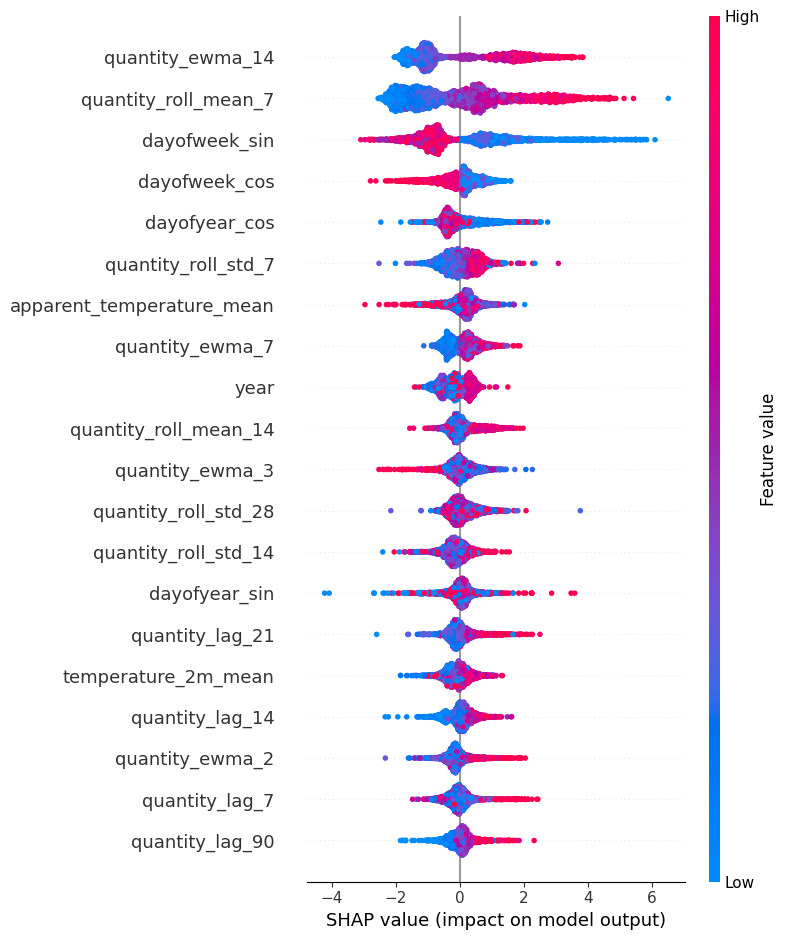

In [17]:
model = xgb.XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            enable_categorical=True,
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            eval_metric="rmse",
            early_stopping_rounds=100
)

model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
)


y_pred = model.predict(X_test)
_ = evaluate_model(y_test, y_pred)


model_final = xgb.XGBRegressor(
                    objective="reg:squarederror",
                    random_state=42,
                    enable_categorical=True,
                    n_estimators=model.best_iteration,
                    learning_rate=0.05,
                    max_depth=6
)
model_final.fit(X_train, y_train)

X_train_dtypes = X_train.dtypes 

print("Calculating SHAP values...")
explainer = shap.Explainer(model_final)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

# Future Data

In [18]:
weather_data = data[['salesDate', 'temperature_2m_mean', 'apparent_temperature_mean']].rename(columns = {"salesDate":"date"}).copy()

In [19]:
weather_data['date'] = pd.to_datetime(weather_data['date'])

mask = weather_data['date'].dt.year.isin([2023, 2024, 2025])
recent_data = weather_data[mask].copy()

recent_data['month_day'] = recent_data['date'].dt.strftime('%m-%d')

avg_temp_by_day = (
    recent_data
    .groupby('month_day')[['temperature_2m_mean', 'apparent_temperature_mean']]
    .mean()
    .reset_index()
)

start_date = pd.to_datetime('2026-01-01')
end_date = pd.to_datetime('2027-04-01')
future_dates = pd.date_range(start=start_date, end=end_date)

future_df = pd.DataFrame({'date': future_dates})
future_df['month_day'] = future_df['date'].dt.strftime('%m-%d')

future_forecast = future_df.merge(avg_temp_by_day, on='month_day', how='left')

future_forecast = future_forecast[['date', 'temperature_2m_mean', 'apparent_temperature_mean']]

weather_data = pd.concat([weather_data,future_forecast], ignore_index=True)

In [20]:
start_date = pd.to_datetime(datetime(2026, 1, 1))
end_date = pd.to_datetime(datetime(2027, 4, 1))


start_date_previous = pd.to_datetime(datetime(2024, 1, 1))
end_date_previous = pd.to_datetime(datetime(2025, 4, 1))

In [21]:
df_all = data[(data["articleGroupDescription"] == article)&
                    (data["salesDate"] < start_date)].sort_values(["articleGroupDescription", "salesDate"]).reset_index(drop=True)

In [22]:
df_all_train = create_features(df_all, "quantity")

df_all_train.tail(1)

Creating all optimized features...
All feature creation complete.


,salesDate,season,articleGroupIdentifier,articleGroupDescription,temperature_2m_mean,apparent_temperature_mean,quantity,year,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,month_sin,month_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,quantity_lag_1,quantity_lag_2,quantity_lag_3,quantity_lag_7,quantity_lag_14,quantity_lag_21,quantity_lag_28,quantity_lag_90,quantity_lag_365,quantity_roll_mean_7,quantity_roll_std_7,quantity_roll_mean_14,quantity_roll_std_14,quantity_roll_mean_28,quantity_roll_std_28,quantity_roll_mean_60,quantity_roll_std_60,quantity_roll_mean_90,quantity_roll_std_90,quantity_ewma_1,quantity_ewma_2,quantity_ewma_3,quantity_ewma_7,quantity_ewma_14,quantity_ewma_28,quantity_ewma_60,quantity_ewma_90
2453,2025-11-09,NOOS,121.0,5-pocket,10.97,9.41,6.0,2025,1,0,0,0,0,0,0,-0.5,0.866025,-0.781831,0.62349,-0.780296,0.625411,11.0,6.0,4.0,4.0,7.0,8.0,1.0,6.0,29.0,4.857143,3.287784,4.642857,3.499608,4.857143,3.638419,4.633333,3.732435,6.544444,5.579177,11.0,9.129025,7.98296,5.884802,5.034934,4.849773,5.379752,5.947451


# Recursive Forecasting for Future Dates

In [23]:
X_train_all, y_train_all = df_all_train[features], df_all_train[target]
y_train_all = y_train_all.values.ravel()

future_predictions = recursive_forecast_single_article(
    df=df_all_train.copy(),
    weather_data=weather_data,
    create_features=create_features,
    model=model_final,
    X_train_columns=X_train_all.columns,
    start_date=start_date,
    end_date=end_date,
    X_train_dtypes=X_train_dtypes
)

print("Recursive forecast complete.")
print(future_predictions.head())

Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating all optimized features...
All feature creation complete.
Creating a

## Check numbers for future forecasts

In [24]:
print(future_predictions[(future_predictions["salesDate"] >= start_date) & (future_predictions["salesDate"] <= end_date)]["pred_quantity"].sum())

6536.559


## Compare historical numbers for same time period

In [25]:
print(data[(data["articleGroupDescription"] == article) & (data["salesDate"] >= start_date_previous) & (data["salesDate"] <= end_date_previous)]["quantity"].sum())

5901.0


In [26]:
article_df = data[data["articleGroupDescription"] == article].copy()

min_year = article_df['salesDate'].dt.year.min()
max_year = article_df['salesDate'].dt.year.max()

results = []

for year in range(min_year, max_year):
    
    start_date = pd.to_datetime(f"{year}-01-01")
    end_date = pd.to_datetime(f"{year+1}-04-01")
    
    mask = (
        (article_df["salesDate"] >= start_date) &
        (article_df["salesDate"] <= end_date)
    )
    
    total_quantity = article_df.loc[mask, "quantity"].sum()
    
    results.append({
        "Window_Start_Year": year,
        "Window_Label": f"Jan {year} - Apr {year+1}",
        "Total_Quantity": total_quantity
    })

historical_comparison = pd.DataFrame(results)

print(f"Historical sales for {article} (15-month window):")
print(historical_comparison)

Historical sales for 5-pocket (15-month window):
   Window_Start_Year         Window_Label  Total_Quantity
0               2019  Jan 2019 - Apr 2020          4022.0
1               2020  Jan 2020 - Apr 2021          3335.0
2               2021  Jan 2021 - Apr 2022          3010.0
3               2022  Jan 2022 - Apr 2023          3622.0
4               2023  Jan 2023 - Apr 2024          6743.0
5               2024  Jan 2024 - Apr 2025          5901.0


# Mathematical Adjustment for forecast

Calculating historical 15-month window sales for 5-pocket...
Calculating current YTD pace (2025 vs 2024)...

--- Final Forecast Summary: 5-pocket ---
📅 Forecast Horizon: 2026-01-01 to 2027-04-01
📈 Raw Model Forecast: 6,537
--- Adjustment Metrics ---
📊 Historical 15-Month Avg. Growth (G_hist): +13.4%
🚀 Current YTD Pace vs. 2024 (G_pace): -39.9%
⚖️ Blended Growth Rate (G_blended): -13.2%

--- Forecast Options ---
1. Raw Model: 6,537
2. Adj. w/ History (G_hist): 7,415
3. Adj. w/ Pace (G_pace): 3,927
4. Adj. w/ Blended Rate (G_blended): 5,671
🔁 Blended Range (±10%): 5,104 – 6,238

📊 Blended vs Raw: -13.2% (↓ decrease)


'Forecasted Sales : '

,salesDate,articleGroupDescription,Approach,SalesForecast
0,2026-01-01 to 2027-04-01,5-pocket,Raw Model,6537.0
1,2026-01-01 to 2027-04-01,5-pocket,Adj: Historical,7415.0
2,2026-01-01 to 2027-04-01,5-pocket,Adj: Pace,3927.0
3,2026-01-01 to 2027-04-01,5-pocket,Adj: Blended,5671.0


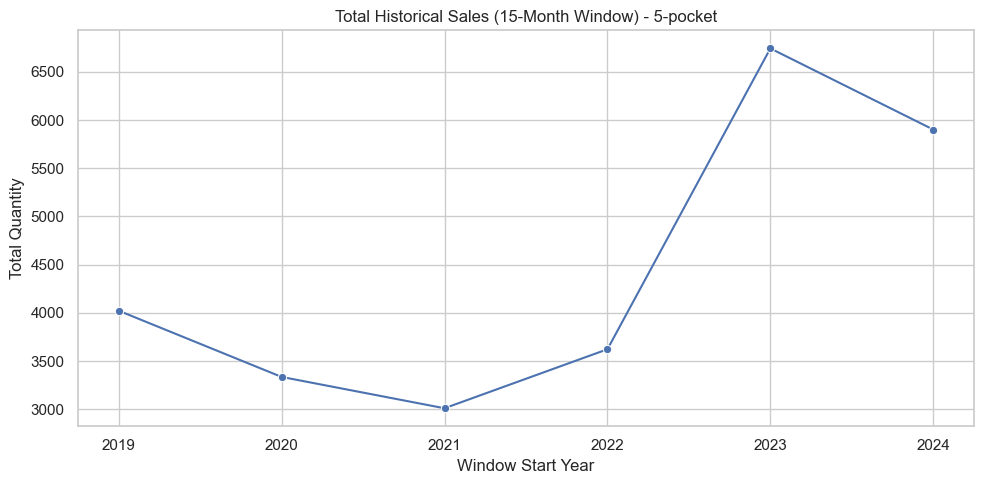

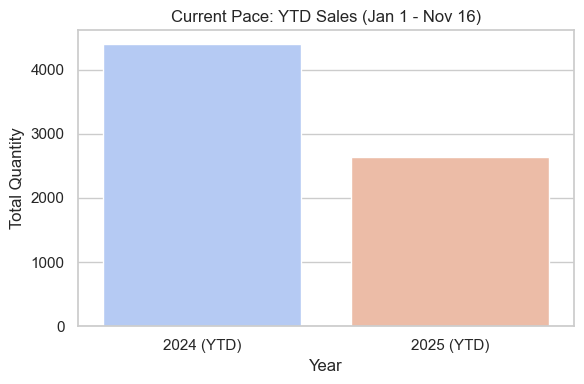

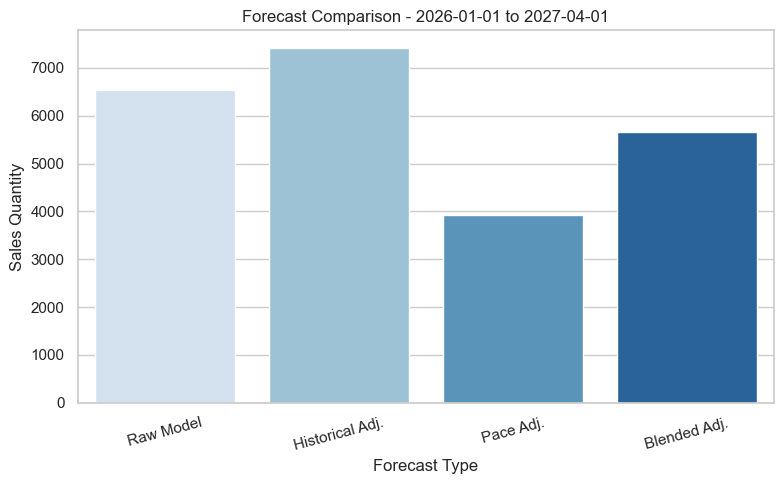

In [27]:
start_year = 2019
last_historical_year = 2025
forecast_start = start_date
forecast_end = end_date
plot_style = "whitegrid"

forecast_start = pd.to_datetime(datetime(2026, 1, 1))
forecast_end = pd.to_datetime(datetime(2027, 4, 1))

today = pd.to_datetime('2025-11-17')
current_ytd_end_date = today - pd.Timedelta(days=1)
previous_ytd_end_date = current_ytd_end_date - pd.DateOffset(years=1)

# ---------- LOAD & FILTER ----------
sub_df = data[data["articleGroupDescription"] == article].copy()
sub_df["quantity"] = pd.to_numeric(sub_df["quantity"], errors="coerce").fillna(0)
sub_df["year"] = sub_df["salesDate"].dt.year

# ---------- STEP 1: HISTORICAL 15-MONTH SALES GROWTH (G_hist) ----------
print(f"Calculating historical 15-month window sales for {article}...")
historical_totals = {}
historical_window_labels = {}

# Loop stops at 2024 (y) so that 'y+1' is 2025 (last_historical_year)
for y in range(start_year, last_historical_year): 
    window_start = pd.to_datetime(f"{y}-01-01")
    window_end = pd.to_datetime(f"{y+1}-04-01")
    mask = (sub_df["salesDate"] >= window_start) & (sub_df["salesDate"] <= window_end)
    
    total_quantity = sub_df.loc[mask, "quantity"].sum()
    window_label = f"Jan {y} - Apr {y+1}"
    historical_totals[y] = total_quantity
    historical_window_labels[y] = window_label

historical_df = pd.DataFrame(list(historical_totals.items()), columns=["Year", "TotalSales_15MonthWindow"])
historical_df["Window_Label"] = historical_df["Year"].map(historical_window_labels)

historical_df["YoY Growth"] = historical_df["TotalSales_15MonthWindow"].pct_change()
G_hist = historical_df["YoY Growth"].dropna().mean()

# ---------- STEP 2: CURRENT PACE (YTD) GROWTH (G_pace) ----------
print(f"Calculating current YTD pace (2025 vs 2024)...")
# Get 2025 YTD Sales (Jan 1, 2025 - Nov 16, 2025)
mask_2025_ytd = (sub_df["salesDate"] >= '2025-01-01') & (sub_df["salesDate"] <= current_ytd_end_date)
sales_2025_ytd = sub_df.loc[mask_2025_ytd, "quantity"].sum()

# Get 2024 YTD Sales (Jan 1, 2024 - Nov 16, 2024)
mask_2024_ytd = (sub_df["salesDate"] >= '2024-01-01') & (sub_df["salesDate"] <= previous_ytd_end_date)
sales_2024_ytd = sub_df.loc[mask_2024_ytd, "quantity"].sum()

# Calculate current pace growth
if sales_2024_ytd > 0:
    G_pace = (sales_2025_ytd - sales_2024_ytd) / sales_2024_ytd
else:
    G_pace = 0 # Avoid division by zero

# Blend the two growth rates
G_blended = (G_hist + G_pace) / 2

# ---------- STEP 3: RAW FORECAST (Full Horizon) ----------
f_mask = (future_predictions["salesDate"] >= forecast_start) & (future_predictions["salesDate"] <= forecast_end)
F_total = future_predictions.loc[f_mask, "pred_quantity"].sum()

# ---------- STEP 4: ADJUSTED FORECASTS ----------
adj_Raw = F_total
adj_Historical = F_total * (1 + G_hist)  # Adjusted by long-term 15-month trend
adj_Pace = F_total * (1 + G_pace)      # Adjusted by current YTD pace
adj_Blended = F_total * (1 + G_blended)  # Adjusted by blended pace/history

forecast_range = {
    "Lower Bound": adj_Blended * 0.9,
    "Upper Bound": adj_Blended * 1.1
}

adjustment_percent = (adj_Blended - adj_Raw) / (adj_Raw if adj_Raw != 0 else 1) * 100
direction = "↑ increase" if adjustment_percent > 0 else "↓ decrease"

# ---------- PRINT SUMMARY ----------
forecast_period_str = f"{forecast_start.strftime('%Y-%m-%d')} to {forecast_end.strftime('%Y-%m-%d')}"
print(f"\n--- Final Forecast Summary: {article} ---")
print(f"📅 Forecast Horizon: {forecast_period_str}")
print(f"📈 Raw Model Forecast: {adj_Raw:,.0f}")
print(f"--- Adjustment Metrics ---")
print(f"📊 Historical 15-Month Avg. Growth (G_hist): {G_hist:+.1%}")
print(f"🚀 Current YTD Pace vs. 2024 (G_pace): {G_pace:+.1%}")
print(f"⚖️ Blended Growth Rate (G_blended): {G_blended:+.1%}")
print(f"\n--- Forecast Options ---")
print(f"1. Raw Model: {adj_Raw:,.0f}")
print(f"2. Adj. w/ History (G_hist): {adj_Historical:,.0f}")
print(f"3. Adj. w/ Pace (G_pace): {adj_Pace:,.0f}")
print(f"4. Adj. w/ Blended Rate (G_blended): {adj_Blended:,.0f}")
print(f"🔁 Blended Range (±10%): {forecast_range['Lower Bound']:,.0f} – {forecast_range['Upper Bound']:,.0f}")
print(f"\n📊 Blended vs Raw: {adjustment_percent:.1f}% ({direction})")

# ---------- SAVE SUMMARY ----------
summary_df = pd.DataFrame({
    "Approach": ["Raw Model", "Adj: Historical", "Adj: Pace", "Adj: Blended"],
    "SalesForecast": [adj_Raw, adj_Historical, adj_Pace, adj_Blended],
})
summary_df["articleGroupDescription"] = article
summary_df["salesDate"] = forecast_period_str
summary_df = summary_df.round({"SalesForecast": 0})
forecasted_data = summary_df[["salesDate", "articleGroupDescription", "Approach", "SalesForecast"]]
display("Forecasted Sales : ", forecasted_data)

# ---------- VISUALIZATION ----------
sns.set_theme(style=plot_style)

# Plot 1: Historical 15-Month Window Sales
plt.figure(figsize=(10, 5))
sns.lineplot(data=historical_df, x="Year", y="TotalSales_15MonthWindow", marker="o")
plt.title(f"Total Historical Sales (15-Month Window) - {article}")
plt.xlabel("Window Start Year")
plt.ylabel("Total Quantity")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: YTD Pace Comparison (2024 vs 2025)
plt.figure(figsize=(6, 4))
ytd_data = pd.DataFrame({
    "Year": ["2024 (YTD)", "2025 (YTD)"],
    "Sales": [sales_2024_ytd, sales_2025_ytd]
})
sns.barplot(data=ytd_data, x="Year", y="Sales", palette="coolwarm")
plt.title(f"Current Pace: YTD Sales (Jan 1 - {current_ytd_end_date.strftime('%b %d')})")
plt.ylabel("Total Quantity")
plt.tight_layout()
plt.show()

# Plot 3: Final Forecast Comparison
plt.figure(figsize=(8, 5))
forecast_bar_data = {
    "Forecast Type": ["Raw Model", "Historical Adj.", "Pace Adj.", "Blended Adj."],
    "Sales Quantity": [adj_Raw, adj_Historical, adj_Pace, adj_Blended]
}
sns.barplot(data=forecast_bar_data, x="Forecast Type", y="Sales Quantity", palette="Blues")
plt.title(f"Forecast Comparison - {forecast_period_str}")
plt.ylabel("Sales Quantity")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Save final forecasted numbers

In [29]:
forecasted_data_to_save = forecasted_data[forecasted_data["Approach"] == "Adj: Historical"]
output_path = f'/Users/trentino/Work/OFM/droplet/2026 Forecast/forecasted_data/{article.lower().replace(" ", "_")}_noos_adjusted.parquet'
forecasted_data_to_save.to_parquet(output_path)